**NOTE:** Please see the notes at the top of 01_migration_graph_basics v1.1.ipynb for v1.1 notes

# Migration Flow Graph Analysis

Building on notebook 01, we will now apply more advanced graph analysis techniques from Lab 2.

Before I get on to trying clustering, path length and degree distributions on the data, I conversed with my favourite Ai and it suggested I also try spring layout and centrality by degree and betweenness. These are all NetworX functions, so I think I'll try those first here then start another workbook covering what we did in the lecture.

**Code Goals:**
- To improve the graph visualisation with better layouts
- To visualise edge weights (migration flow sizes)
- To calculate and visualise node importance (centrality metrics)
- Identify key migration hubs

## Setup (re-loading)

The following code re-loads & rebuilds the graph from the prevoius notebook for us to continue building on. Any additions are commented as **# NEW!** . There were only minor updates made this time around. To understand anything here, check back over the previous workbook.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import warnings # NEW! Added this time to supress benign warnings
warnings.filterwarnings('ignore', category=UserWarning) # NEW! Added this time to supress benign warnings
np.random.seed(99) # Set random seed for reproducibility
df = pd.read_csv('../data/bilat_mig_40_countries.csv')# Load the migration data
# Rebuild the directed graph
G = nx.DiGraph()
for index, row in df.iterrows():
    if row['da_pb_closed'] > 0:
        G.add_edge(row['orig'], row['dest'], weight=row['da_pb_closed'])
print("Libraries loaded and graph rebuilt successfully!")
print(f"Graph: {G.number_of_nodes()} countries, {G.number_of_edges()} migration flows")

Libraries loaded and graph rebuilt successfully!
Graph: 40 countries, 1408 migration flows


## Improved Visualisation

We will now use a spring layout, where:

- Nodes repel each other (like springs)
- Connected nodes attract each other
- Results in more natural clustering

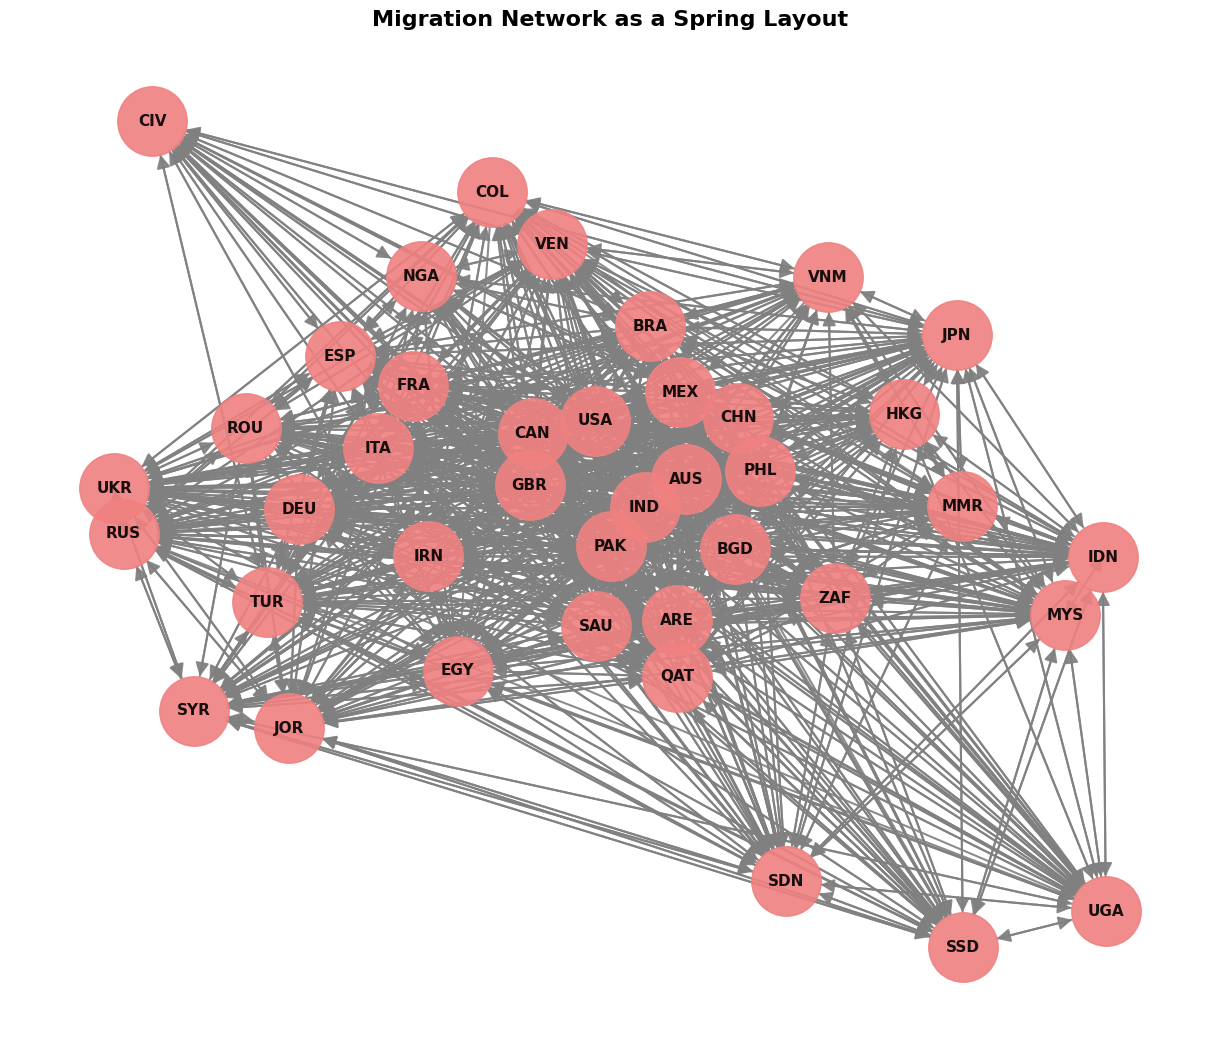

Spring layout visualisation complete!
Notice: Countries with stronger connections are positioned closer together


In [4]:
# Create a spring layout using physics simulation k controls the distance between nodes (higher = more spread out),
# iterations controls how long the simulation runs, seed ensures consistent layout each time

pos = nx.spring_layout(G, k=2, iterations=50, seed=99) #Runs physics simulation to position nodes, adjust k=2 for spacing but I can't see the difference?

# Draw the graph with spring layout
plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=True, node_color='lightcoral', node_size=2500, font_size=11, font_weight='bold', arrows=True, arrowsize=20, edge_color='gray', width=1.5, alpha=0.9)

plt.title("Migration Network as a Spring Layout", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Spring layout visualisation complete!")
print("Notice: Countries with stronger connections are positioned closer together")

### Visualisation Inference for Report v1.1

Not quite a two-stage scenario but there's definitely the ndoes on the outer ring, and thsoe on an internal ring.



## Node Sizing by Migration Volume

Let's make node sizes proportional to total migration (in + out).

**Steps:**
- Calculate total incoming migration for each country
- Calculate total outgoing migration for each country
- Combine them to get total migration volume
- Use this to size nodes in visualization

TODO: Calculate migration volumes and visualize with sized nodes

Top Countries by Total Migration Volume (In + Out)
1. USA: 14,455,951 migrants (In: 10,486,086, Out: 3,969,865)
2. IND: 8,397,666 migrants (In: 3,403,173, Out: 4,994,493)
3. PAK: 7,817,570 migrants (In: 564,224, Out: 7,253,346)
4. SAU: 6,049,704 migrants (In: 2,614,961, Out: 3,434,743)
5. BGD: 6,011,354 migrants (In: 882,129, Out: 5,129,225)
6. GBR: 4,407,334 migrants (In: 2,980,327, Out: 1,427,007)
7. MEX: 4,072,396 migrants (In: 1,460,356, Out: 2,612,040)
8. DEU: 4,005,858 migrants (In: 2,763,690, Out: 1,242,168)
9. CHN: 3,720,581 migrants (In: 1,352,816, Out: 2,367,765)
10. CAN: 3,547,344 migrants (In: 2,545,434, Out: 1,001,910)
11. ARE: 3,004,690 migrants (In: 1,737,472, Out: 1,267,218)
12. RUS: 2,864,025 migrants (In: 1,999,911, Out: 864,113)
13. VEN: 2,796,746 migrants (In: 396,664, Out: 2,400,083)
14. TUR: 2,639,665 migrants (In: 1,800,334, Out: 839,331)
15. ITA: 2,541,997 migrants (In: 1,427,150, Out: 1,114,847)
16. AUS: 2,531,419 migrants (In: 1,743,042, Out: 788,377)
17. COL:

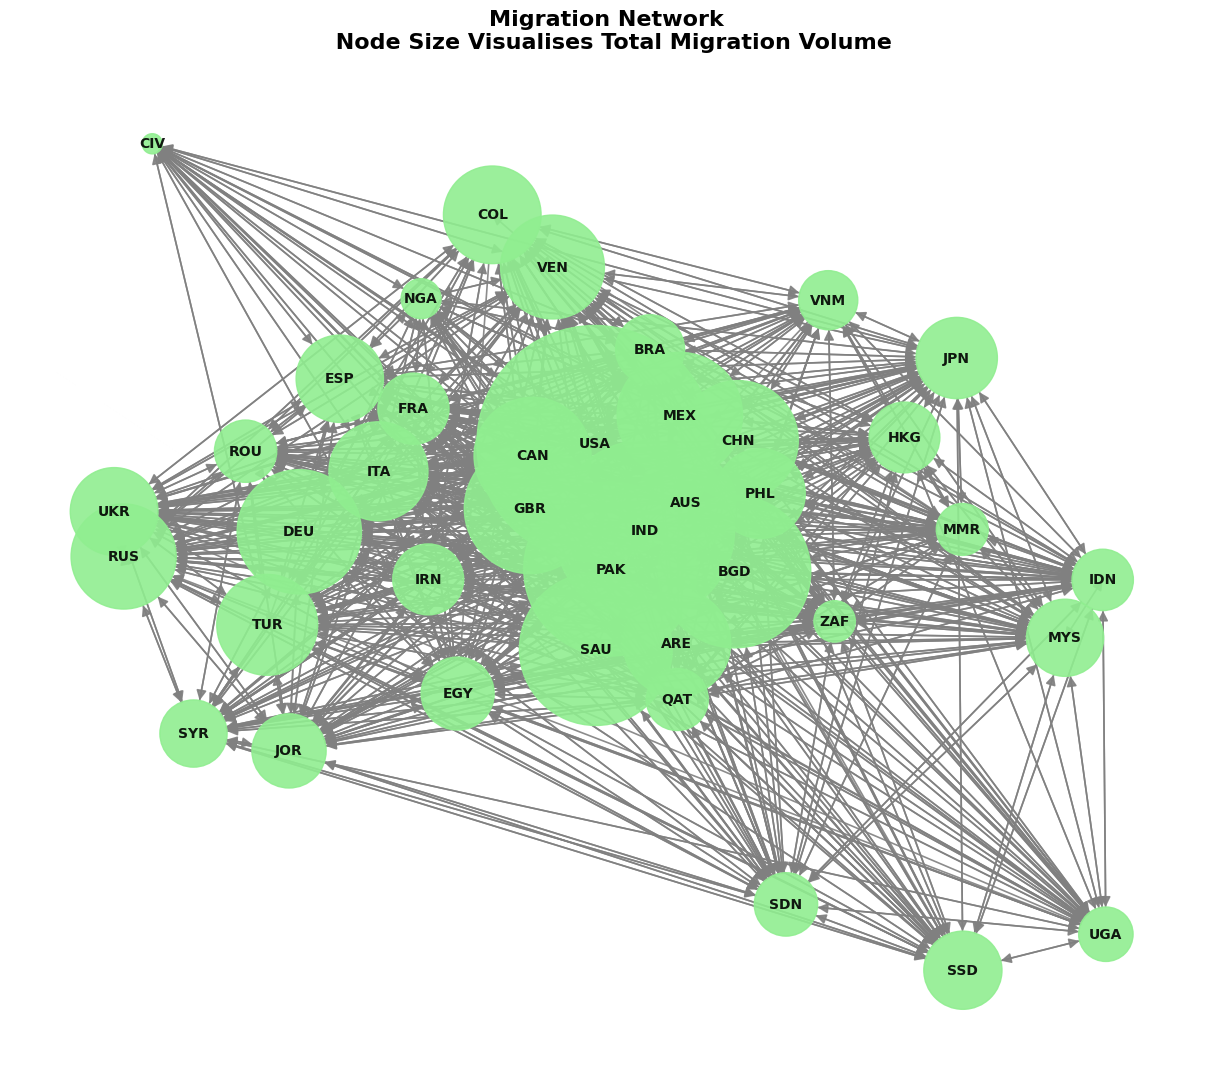

In [6]:
# Calculate weighted in-degree and out-degree for each country
in_migration = dict(G.in_degree(weight='weight'))
out_migration = dict(G.out_degree(weight='weight'))

# Calculate total migration volume (incoming + outgoing)
total_migration = {node: in_migration[node] + out_migration[node] for node in G.nodes()}

# Print top countries by migration volume
print("="*60)
print("Top Countries by Total Migration Volume (In + Out)")
print("="*60)
sorted_countries = sorted(total_migration.items(), key=lambda x: x[1], reverse=True)
for i, (country, volume) in enumerate(sorted_countries, 1):
    print(f"{i}. {country}: {volume:,.0f} migrants (In: {in_migration[country]:,.0f}, Out: {out_migration[country]:,.0f})")

# Visualize with node sizes proportional to migration volume
# Scale node sizes for visibility (divide by a constant)
node_sizes = [total_migration[node]/500 for node in G.nodes()]

plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=node_sizes, font_size=10, font_weight='bold', arrows=True, arrowsize=15, edge_color='gray', width=1.2, alpha=0.9)

plt.title("Migration Network \n Node Size Visualises Total Migration Volume", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Visualisation Inference for Report v1.1

By total migration, most are closer to the middle but not all. I think a lot of meaning is lost here as the colours all blur the centre circles together - we may need to re-jig this one to give each country a unique shade or be click-able to identify it from its neighbour. 

## Centrality Metrics

**Centrality** is a measure of node importance.

**Degree Centrality:**
- How many connections does a node have?
- High degree = well-connected country

**Betweenness Centrality:**
- How often does a node appear on shortest paths between other nodes?
- High betweenness = country is a "bridge" or "hub"

Top Countries by Degree Centrality (Connectivity)
1. ZAF: 2.000
2. CHN: 2.000
3. JPN: 2.000
4. IND: 2.000
5. TUR: 2.000

Top Countries by Betweenness Centrality (Bridge Position)
1. MMR: 0.777
2. SDN: 0.485
3. SSD: 0.371
4. DEU: 0.345
5. VEN: 0.226


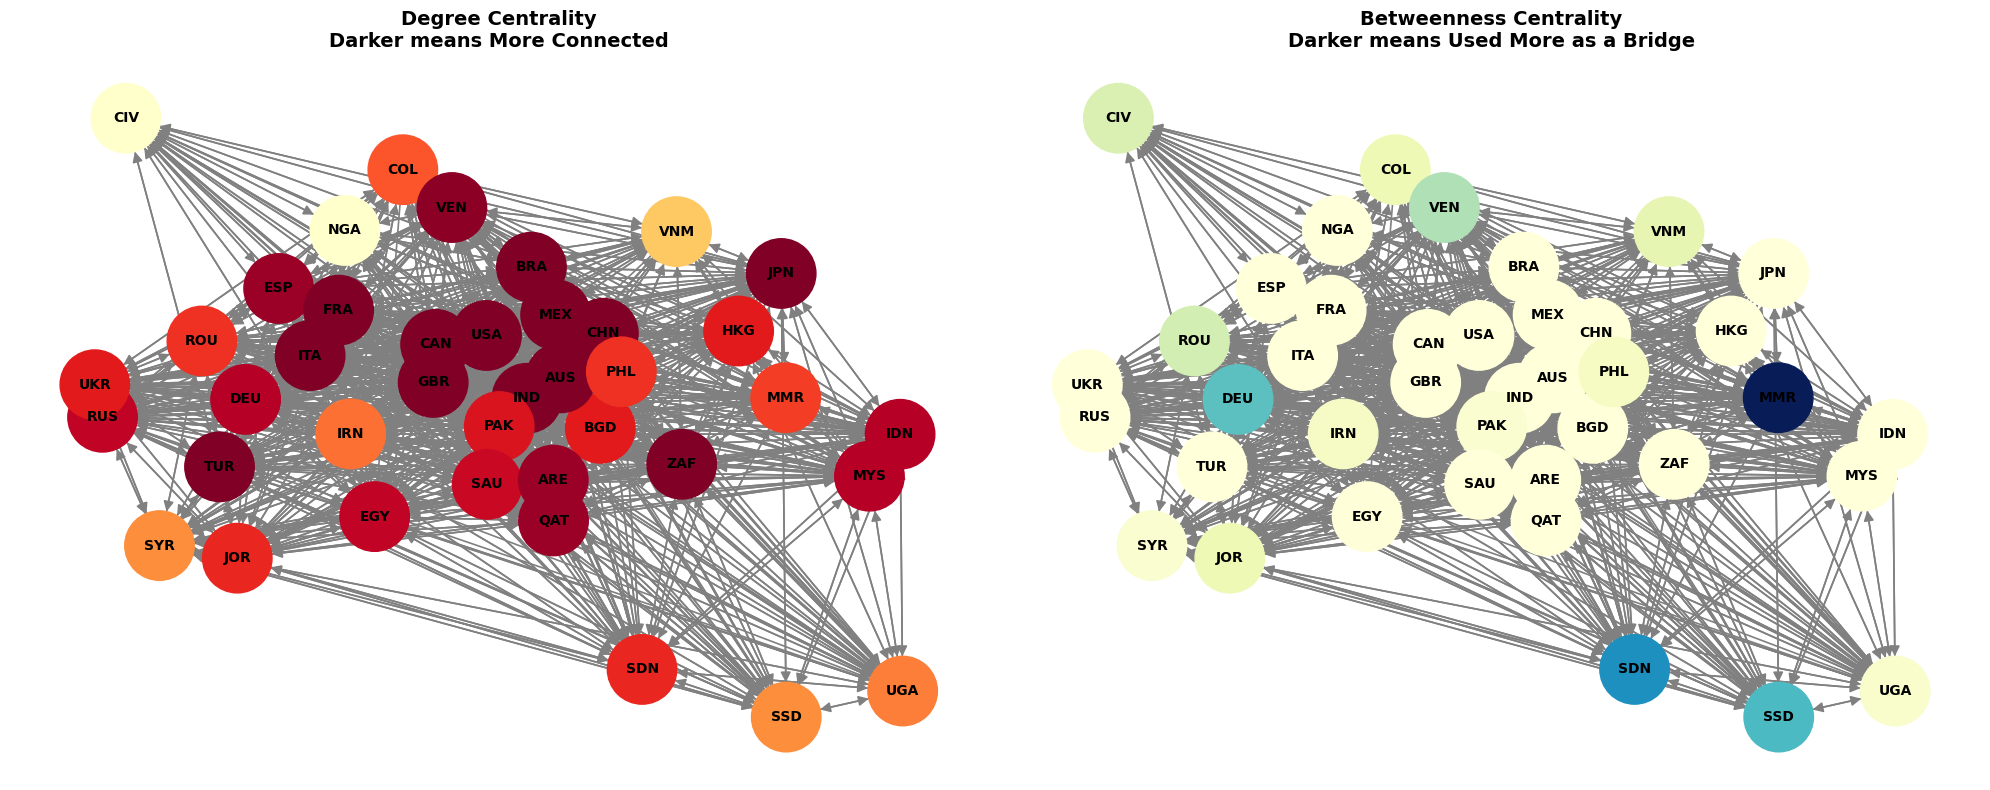

In [7]:
degree_centrality = nx.degree_centrality(G) # Calculate degree centrality (how well-connected is each country?)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight') # Calculate betweenness centrality (how often is each country on paths betweenothers?)

print("="*60) # Print top countries by degree centrality
print("Top Countries by Degree Centrality (Connectivity)")
print("="*60)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
for i, (country, score) in enumerate(sorted_degree[:5], 1):
    print(f"{i}. {country}: {score:.3f}")

print("\n" + "="*60)
print("Top Countries by Betweenness Centrality (Bridge Position)")
print("="*60)
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
for i, (country, score) in enumerate(sorted_betweenness[:5], 1):
    print(f"{i}. {country}: {score:.3f}")

# Create side-by-side visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left plot: Degree centrality
node_colors_degree = [degree_centrality[node] for node in G.nodes()]
nx.draw(G, pos, ax=ax1, with_labels=True, node_color=node_colors_degree, cmap='YlOrRd', node_size=2500, font_size=10, font_weight='bold', arrows=True, arrowsize=15, edge_color='gray', width=1.2, vmin=min(node_colors_degree), vmax=max(node_colors_degree))
ax1.set_title("Degree Centrality\nDarker means More Connected", fontsize=14, fontweight='bold')

# Right plot: Betweenness centrality
node_colors_between = [betweenness_centrality[node] for node in G.nodes()] 
nx.draw(G, pos, ax=ax2, with_labels=True, node_color=node_colors_between, cmap='YlGnBu', node_size=2500, font_size=10, font_weight='bold', arrows=True, arrowsize=15, edge_color='gray', width=1.2, vmin=min(node_colors_between), vmax=max(node_colors_between))
ax2.set_title("Betweenness Centrality\nDarker means Used More as a Bridge", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Visualisation Inference for Report v1.1

Most countries well-connected (35-39 connections), but peripheral countries like Nigeria, Côte d'Ivoire show ~50% fewer connections, suggesting a core-periphery structure.

## Identify Key Migration Hubs

Which countries are the most important in the migration network? I'll create a bunch of chats here based on the above metrics and draw some inferences from them.

Migration Hub Rankings - All Metrics
Country  Total_Migration  In_Migration  Out_Migration  Degree_Centrality  Betweenness_Centrality
    USA      14455951.13   10486086.27     3969864.86           2.000000                0.000000
    IND       8397665.99    3403172.55     4994493.44           2.000000                0.000000
    PAK       7817570.10     564223.92     7253346.18           1.794872                0.024966
    SAU       6049703.83    2614961.22     3434742.61           1.846154                0.000000
    BGD       6011354.17     882128.76     5129225.41           1.769231                0.000000
    GBR       4407334.04    2980327.32     1427006.72           2.000000                0.000000
    MEX       4072396.29    1460356.34     2612039.95           2.000000                0.000000
    DEU       4005858.05    2763689.55     1242168.50           1.897436                0.345142
    CHN       3720581.02    1352815.70     2367765.32           2.000000                0.

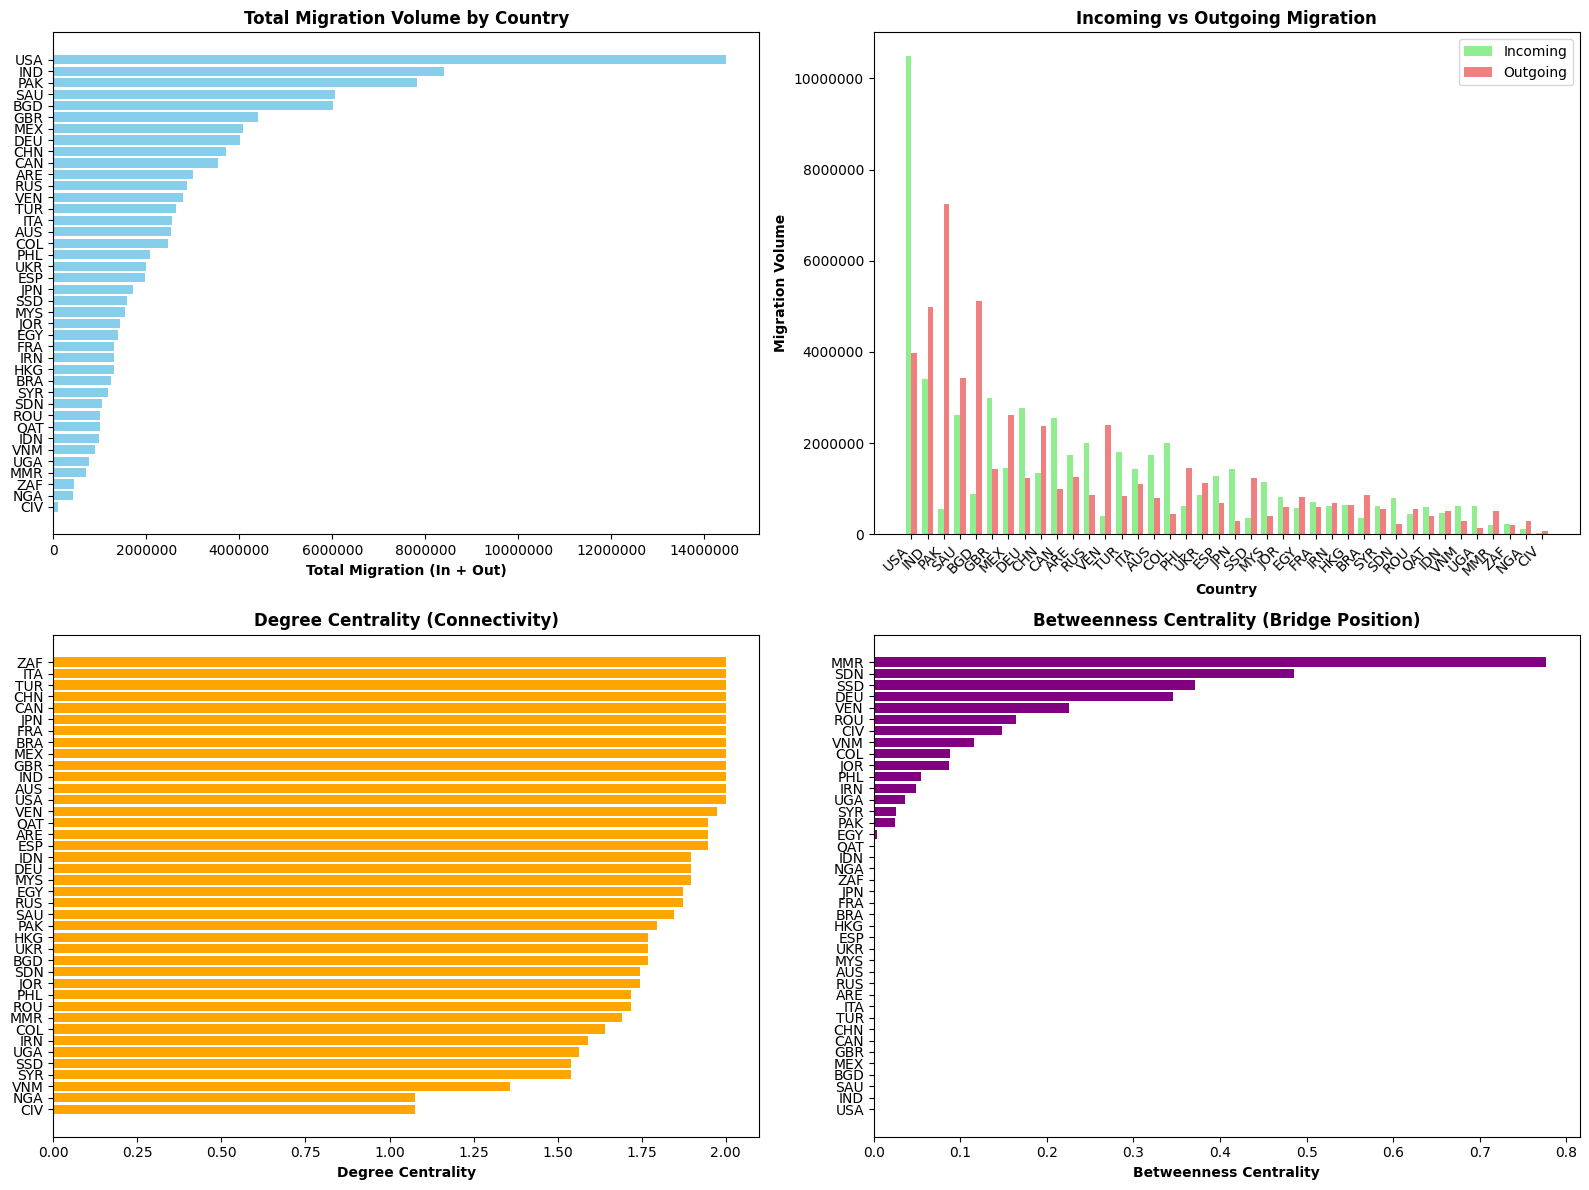


Analysis complete! Review the metrics above to identify key migration hubs.


In [8]:
# Create a summary DataFrame combining all metrics
summary_data = {'Country': list(G.nodes()), 'Total_Migration': [total_migration[node] for node in G.nodes()], 'In_Migration': [in_migration[node] for node in G.nodes()], 'Out_Migration': [out_migration[node] for node in G.nodes()], 'Degree_Centrality': [degree_centrality[node] for node in G.nodes()], 'Betweenness_Centrality': [betweenness_centrality[node] for node in G.nodes()] }
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Total_Migration', ascending=False) # Sort by total migration volume
# Prints a summary table with all metrics in one place
print("="*80)
print("Migration Hub Rankings - All Metrics")
print("="*80)
print(summary_df.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(16, 12)) # Create a bar chart comparing countries

# Plot 1: Total Migration Volume (horizontal bar)
ax = axes[0, 0]
countries_sorted = summary_df.sort_values('Total_Migration', ascending=True)
ax.barh(countries_sorted['Country'], countries_sorted['Total_Migration'], color='skyblue')
ax.set_xlabel('Total Migration (In + Out)', fontweight='bold')
ax.set_title('Total Migration Volume by Country', fontweight='bold', fontsize=12)
ax.ticklabel_format(axis='x', style='plain')

# Plot 2: In vs Out Migration (grouped bars)
ax = axes[0, 1]
x = np.arange(len(summary_df))
width = 0.35
ax.bar(x - width/2, summary_df['In_Migration'], width, label='Incoming', color='lightgreen')
ax.bar(x + width/2, summary_df['Out_Migration'], width, label='Outgoing', color='lightcoral')
ax.set_xlabel('Country', fontweight='bold')
ax.set_ylabel('Migration Volume', fontweight='bold')
ax.set_title('Incoming vs Outgoing Migration', fontweight='bold', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(summary_df['Country'], rotation=45, ha='right')
ax.legend()
ax.ticklabel_format(axis='y', style='plain')

# Plot 3: Degree Centrality (comparison)
ax = axes[1, 0]
countries_sorted = summary_df.sort_values('Degree_Centrality', ascending=True)
ax.barh(countries_sorted['Country'], countries_sorted['Degree_Centrality'], color='orange')
ax.set_xlabel('Degree Centrality', fontweight='bold')
ax.set_title('Degree Centrality (Connectivity)', fontweight='bold', fontsize=12)

# Plot 4: Betweenness Centrality (should show Syria's bridge role clearly)
ax = axes[1, 1]
countries_sorted = summary_df.sort_values('Betweenness_Centrality', ascending=True)
ax.barh(countries_sorted['Country'], countries_sorted['Betweenness_Centrality'], color='purple')
ax.set_xlabel('Betweenness Centrality', fontweight='bold')
ax.set_title('Betweenness Centrality (Bridge Position)', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print("\nAnalysis complete! Review the metrics above to identify key migration hubs.")

### Visualisation Inference for Report v1.1

Total volume by country - interesting on a global scale, would be interesting to weigh against the population size
Incoming vs Outgoing Migration - very interesting, what do countries who have outgoing vs incoming (and viceversa) have in common?
Degree Centrality - Worth doing and better then the previous graph, identifies some countries nearly 50% less connected! But the majority are still similar
Bridge Centrality - I'm not sure what to make of this yet, this is not a transit hub (I made this thought mistake), but a mathamatical anomoly in the connectivity of nodes. They're graph-theoretic bridges. That said Myanmar (0.777) is not an anomaly, it's the ONLY connection between certain country pairs, so perhaps people staying while transitting through? it does bridge the South East Asia >> Middle East labour migration corrador